In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
plt.style.use("seaborn")
%matplotlib inline

C:\Users\dell\AppData\Local\Temp\ipykernel_11000\282663358.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [2]:
NonViolenceImages_Dir = "dataset/NonViolence"
ViolenceImages_Dir = "dataset/Violence"

# Specify the image dimensions
IMAGE_HEIGHT, IMAGE_WIDTH = 75, 75

# Dataset directory and class labels
DATASET_DIR = "dataset"
CLASSES_LIST = ["NonViolence", "Violence"]

In [3]:
def load_and_preprocess_image(image_path):
    # Read the image
    image = cv2.imread(image_path)
    
    # Check if image was successfully loaded
    if image is None:
        return None
    
    # Resize the image to the specified size
    resized_image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
    
    # Normalize the image
    normalized_image = resized_image / 255.0
    
    return normalized_image

In [4]:
def create_image_dataset():
    features = []
    labels = []
    image_files_paths = []

    # Iterate through all the classes (NonViolence, Violence)
    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Loading Data for Class: {class_name}')
        
        # Get the list of image files in the specific class directory
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through each image file
        for file_name in files_list:
            # Get the full path of the image
            image_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            
            # Load and preprocess the image
            image = load_and_preprocess_image(image_file_path)
            
            # Check if the image was loaded properly
            if image is not None:
                # Append the image data and label to respective lists
                features.append(image)
                labels.append(class_index)
                image_files_paths.append(image_file_path)

    # Convert features and labels to numpy arrays
    features = np.asarray(features)
    labels = np.asarray(labels)

    return features, labels, image_files_paths


In [5]:
features, labels, image_files_paths = create_image_dataset()


Loading Data for Class: NonViolence
Loading Data for Class: Violence


In [6]:
np.save("features.npy",features)
np.save("labels.npy",labels)
np.save("image_files_paths.npy",image_files_paths)

In [7]:
features, labels, image_files_paths = np.load("features.npy") , np.load("labels.npy") ,  np.load("image_files_paths.npy")

In [8]:
# convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [9]:
# Split the Data into Train ( 90% ) and Test Set ( 10% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.1,
                                                                            shuffle = True, random_state = 42)

In [10]:
print(features_train.shape,labels_train.shape )
print(features_test.shape, labels_test.shape)

(8053, 75, 75, 3) (8053, 2)
(895, 75, 75, 3) (895, 2)


In [11]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, LSTM, Bidirectional, TimeDistributed

In [12]:
inception = InceptionV3(include_top=False, weights='imagenet')

# Fine-Tune: Make the last 40 layers trainable
inception.trainable = True
for layer in inception.layers[:-40]:
    layer.trainable = False

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.applications import InceptionV3

def create_model():
    # Define the input shape and initialize InceptionV3 as the base model
    base_model = InceptionV3(
        include_top=False,  # Exclude the final dense layers of InceptionV3
        weights='imagenet',  # Use pre-trained weights
        input_shape=(75, 75, 3)  # Ensure input size is 299x299 for InceptionV3
    )
    
    # Create the model
    model = Sequential()
    model.add(base_model)
    model.add(Dropout(0.25))
    model.add(Flatten())  # Flatten the extracted features before the Dense layers
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))  # Adjust for number of classes
    
    model.summary()
    return model


In [14]:
IncepBiLSTM_model = create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 1, 1, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0

In [15]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=10,             # Number of epochs with no improvement to wait
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity
)

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',      # Monitor validation loss
    factor=0.6,              # Factor by which the learning rate will be reduced
    patience=5,             # Number of epochs with no improvement to wait
    min_lr=0.00005,          # Lower bound on the learning rate
    verbose=1                # Verbosity mode
)

# Assuming MoBiLSTM_model is your image classification model
# Compile the model
IncepBiLSTM_model.compile(
    loss='categorical_crossentropy',  # Loss function for multi-class classification
    optimizer='adam',                  # Use Adam optimizer for better convergence
    metrics=['accuracy']              # Metric to monitor during training
)

# Fit the model
IncepBiLSTM_model_history = IncepBiLSTM_model.fit(
    x=features_train,                 # Training features
    y=labels_train,                   # Training labels
    epochs=20,                        # Number of epochs
    batch_size=8,                     # Batch size
    shuffle=True,                     # Shuffle training data before each epoch
    validation_split=0.2,             # Use 20% of data for validation
    callbacks=[early_stopping_callback, reduce_lr_callback]  # Include callbacks
)


Epoch 1/20
806/806 [==============================] - 559s 631ms/step - loss: 0.7533 - accuracy: 0.5118 - val_loss: 2.2958 - val_accuracy: 0.5462 - lr: 0.0010
Epoch 2/20
806/806 [==============================] - 464s 576ms/step - loss: 0.6937 - accuracy: 0.5314 - val_loss: 0.6897 - val_accuracy: 0.5462 - lr: 0.0010
Epoch 3/20
806/806 [==============================] - 402s 499ms/step - loss: 0.6922 - accuracy: 0.5310 - val_loss: 0.6897 - val_accuracy: 0.5462 - lr: 0.0010
Epoch 4/20
806/806 [==============================] - 396s 492ms/step - loss: 0.6920 - accuracy: 0.5323 - val_loss: 0.6890 - val_accuracy: 0.5462 - lr: 0.0010
Epoch 5/20
806/806 [==============================] - 391s 486ms/step - loss: 0.6959 - accuracy: 0.5312 - val_loss: 0.6902 - val_accuracy: 0.5462 - lr: 0.0010
Epoch 6/20
806/806 [==============================] - 392s 487ms/step - loss: 0.6942 - accuracy: 0.5335 - val_loss: 0.6894 - val_accuracy: 0.5462 - lr: 0.0010
Epoch 7/20
806/806 [==========================

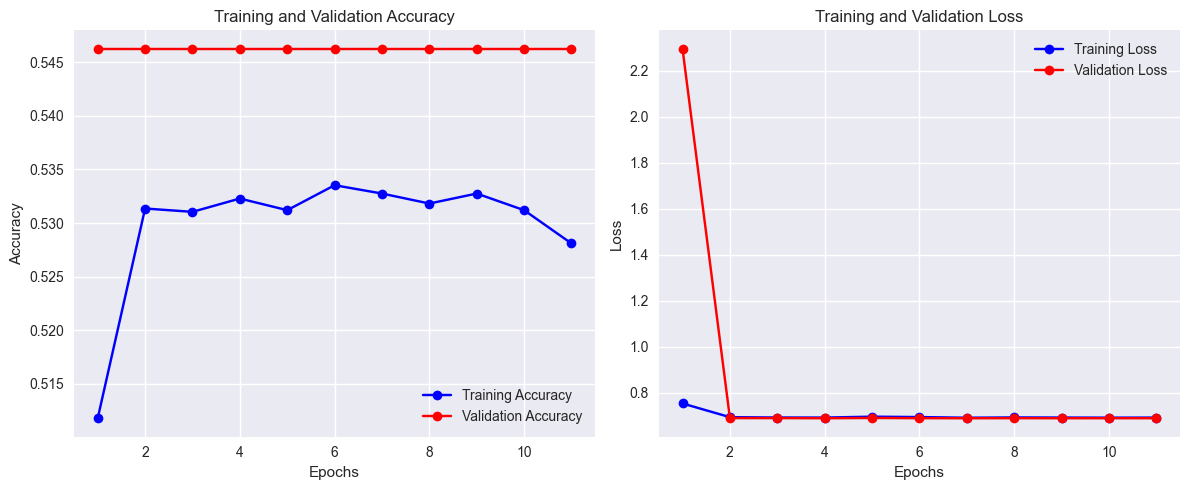

In [16]:
import matplotlib.pyplot as plt

# Extract history metrics
history = IncepBiLSTM_model_history.history
epochs = range(1, len(history['accuracy']) + 1)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history['accuracy'], 'bo-', label='Training Accuracy')
plt.plot(epochs, history['val_accuracy'], 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(epochs, history['loss'], 'bo-', label='Training Loss')
plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


252/252 [==============================] - 29s 105ms/step


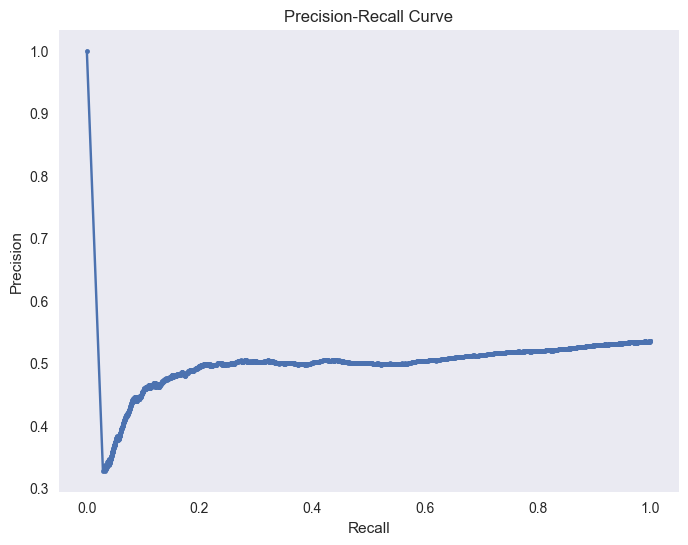

In [19]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# Predict probabilities
y_pred_probs = IncepBiLSTM_model.predict(features_train)

# Convert probabilities to labels if needed
y_true_classes = np.argmax(labels_train, axis=1)

# Get precision-recall curve data
precision, recall, _ = precision_recall_curve(y_true_classes, y_pred_probs[:, 1], pos_label=1)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()


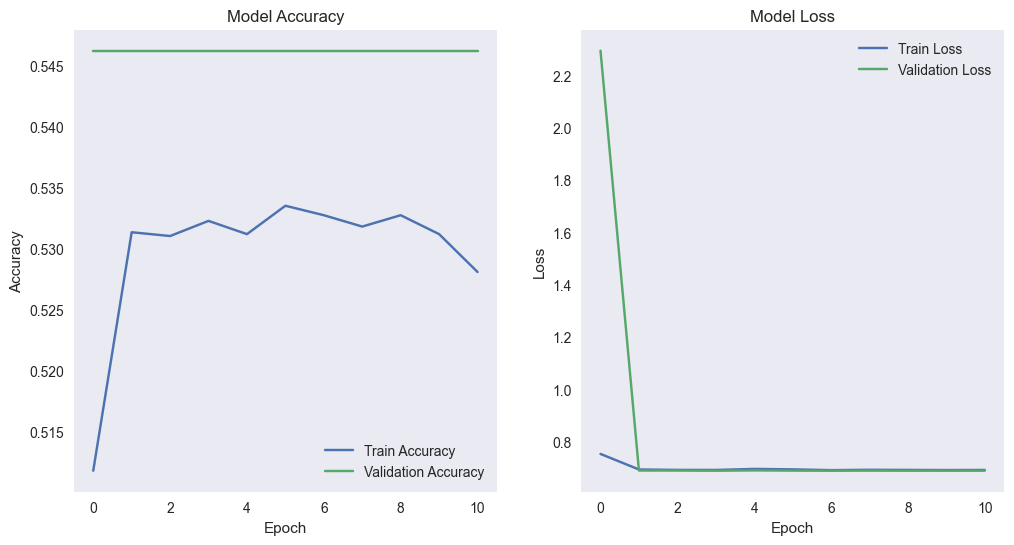

In [21]:
# Extract training history
history = IncepBiLSTM_model_history.history

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.show()
